In [ ]:
"""
this notebook is based on 
https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

"""

In [ ]:
# install transformers library
!pip install transformers

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from google.colab import drive
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import regex as re
import seaborn as sns
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

# optimizer from hugging face transformers
from transformers import AdamW

# specify GPU
device = torch.device("cuda")

RND = 2020

     |████████████████████████████████| 1.1MB 5.8MB/s 
     |████████████████████████████████| 890kB 36.7MB/s 
     |████████████████████████████████| 3.0MB 21.9MB/s 
     |████████████████████████████████| 1.1MB 50.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=85814a8dd90d9670597af4ea7de6fe5bf0053ea2f5c9c4ceabfd556ad30f4557
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Load Data

In [ ]:
drive.mount('/content/drive', force_remount=True)
PATH = '/content/drive/My Drive/DS4A-Project/Data/political_news/'


#import os
#os.chdir("/content/drive/My Drive")
#!ls

Mounted at /content/drive


In [ ]:
bert_data = pd.read_csv(PATH + 'BERT_data.csv')

In [ ]:
bert_data.head()

,subject,fake_flag,title_text_BERT
0,News,1,Donald Trump Sends Out Embarrassing New Year’...
1,News,1,Drunk Bragging Trump Staffer Started Russian ...
2,News,1,Sheriff David Clarke Becomes An Internet Joke...
3,News,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,News,1,Pope Francis Just Called Out Donald Trump Dur...


In [ ]:
bert_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subject          44898 non-null  object
 1   fake_flag        44898 non-null  int64 
 2   title_text_BERT  44898 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


           subject  title_text_BERT
fake_flag                          
0            21417            21417
1            23481            23481


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


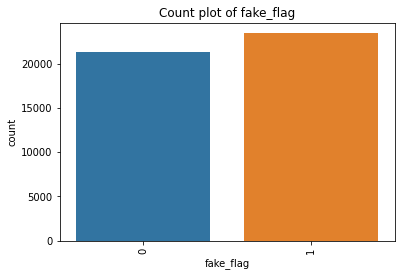

In [ ]:
plt.figure()
sns.countplot(bert_data['fake_flag'])
plt.xticks(rotation = 90)
plt.title("Count plot of fake_flag")

print(bert_data.groupby('fake_flag').count())

In [ ]:
# split train dataset into train, validation and test sets
test_size = 0.3

train_text, temp_text, train_labels, temp_labels = train_test_split(bert_data['title_text_BERT'], 
                                                                    bert_data['fake_flag'], 
                                                                    random_state=RND, 
                                                                    test_size=test_size, 
                                                                    stratify=bert_data['fake_flag'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=RND, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


############################ COMMENT OUT CODE BELOW ############################################
#double checking classes are balanced
# plt.figure()
# small_data = bert_data.sample(frac=0.2, replace=False, random_state=RND)
# sns.countplot(small_data['fake_flag'])
# plt.xticks(rotation = 90)
# plt.title("Count plot of fake_flag")

# print(small_data.groupby('fake_flag').count())

# # split train dataset into train, validation and test sets
# train_text, temp_text, train_labels, temp_labels = train_test_split(small_data['title_text_BERT'], 
#                                                                     small_data['fake_flag'], 
#                                                                     random_state=RND, 
#                                                                     test_size=test_size, 
#                                                                     stratify=small_data['fake_flag'])

# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=RND, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)



# BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus([train_text.array[200]], padding=True)

# output
print(sent_id)

# to test tokenizer
#tokenizer.tokenize(string)

print(tokenizer.tokenize(train_text.array[200]))

{'input_ids': [[101, 3422, 1024, 2023, 3976, 3238, 2678, 26316, 2135, 14451, 2015, 8398, 1998, 2010, 3460, 2005, 2054, 2027, 2428, 2024, 1012, 3404, 6057, 2030, 3280, 2000, 2272, 2039, 2007, 2242, 2066, 2023, 1012, 2027, 1521, 2310, 2207, 1037, 2678, 4626, 12895, 8560, 2099, 1010, 1037, 1012, 1047, 1012, 1037, 2852, 1012, 7929, 4609, 2013, 4336, 2154, 1010, 1998, 2951, 2013, 2732, 10313, 1024, 1996, 2279, 4245, 1010, 1998, 2002, 1006, 6289, 6633, 1007, 3138, 2006, 1037, 2047, 2535, 2182, 2000, 10437, 7828, 1996, 3109, 2041, 1997, 2119, 8398, 1998, 2010, 24209, 8684, 1997, 1037, 3460, 1012, 8560, 2099, 2941, 13999, 2370, 2004, 2852, 1012, 2141, 8602, 1010, 1998, 3202, 18989, 2046, 2054, 2002, 4282, 2055, 8398, 1024, 1045, 1521, 1049, 2437, 2023, 2678, 2138, 2045, 1521, 1055, 2242, 2027, 2123, 1521, 1056, 2215, 2017, 2000, 2113, 1012, 8398, 1521, 1055, 2025, 2013, 2182, 999, 1998, 1045, 2123, 1521, 1056, 2812, 2025, 2013, 2637, 1010, 1045, 2812, 2025, 2013, 2023, 4774, 1010, 3100, 1029, 

In [ ]:
train_text.array[200]

' WATCH: This Priceless Video HILARIOUSLY Exposes Trump And His Doctor For What They Really Are. Trust Funny Or Die to come up with something like this. They’ve released a video starring Brent Spiner, a.k.a Dr. Okun from Independence Day, and Data from Star Trek: The Next Generation, and he (ahem) takes on a new role here to lampoon the hell out of both Trump and his quack of a doctor.Spiner actually introduces himself as Dr. Bornstein, and immediately launches into what he knows about Trump: I’m making this video because there’s something they don’t want you to know. Trump’s not from here! And I don’t mean not from America, I mean not from this planet, okay?When I wrote that ridiculously glowing letter in five minutes, I thought you d see through it for the obvious farce that it was! Indeed, that letter has been the subject of controversy for Trump, seeing as how Bornstein used language that doctors generally don’t use in it. He said that Trump’s lab results were astonishingly excelle

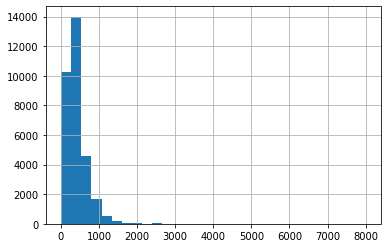

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# most data samples have max length of 1000

max_len = 512
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_len,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_len,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_len,
    padding='max_length',
    truncation=True
)

In [ ]:
# convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#define a batch size
batch_size = 32

#TRAIN
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#VAL
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

#TEST
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, batch_size=batch_size)


# 3 Ways to Train

1. Train the whole BERT model
2. Freeze some layers and train the rest (can define which layers to freeze)
3. Freeze the whole BERT model and add some extra layers to train

## Training using Method #1

## Training using Method #2

## Training using Method #3

In [ ]:
# freeze all the parameters

for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

# define the loss function
cross_entropy  = nn.NLLLoss()

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# number of training epochs
epochs = 5

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), PATH + 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.527
Validation Loss: 0.377

 Epoch 2 / 5
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [ ]:
#load weights of best model
model_state_file = 'saved_weights.pt'
model.load_state_dict(torch.load(PATH+model_state_file))

<All keys matched successfully>

In [ ]:
# # get predictions for test data
# with torch.no_grad():
#   preds = model(test_seq.to(device), test_mask.to(device)) #push to gpu
#   preds = preds.detach().cpu().numpy()

In [ ]:
def prediction():
  
  print("\nGetting Prediction on Test Data...")
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch



    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return total_preds

In [ ]:
preds = prediction()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))


Getting Prediction on Test Data...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3213
           1       0.96      0.90      0.93      3522

    accuracy                           0.93      6735
   macro avg       0.93      0.93      0.93      6735
weighted avg       0.93      0.93      0.93      6735



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

# row_0 is test_y
# column_0 is preds

col_0,0,1
row_0,,
0,3090,123
1,345,3177


AUC: 0.9319


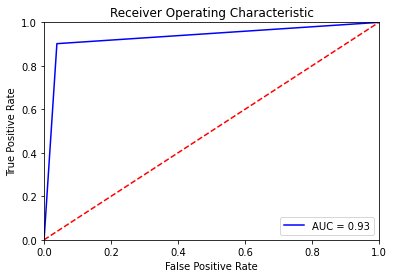

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# get predictions for a random peice of news

new_new = ["President Trump is a man"]

max_len = 512

# tokenize and encode sequences in the training set
tokens_new = tokenizer.batch_encode_plus(
    new_new,
    max_length = max_len,
    padding='max_length',
    truncation=True
)

# convert lists to tensors
new_seq = torch.tensor(tokens_new['input_ids'])
new_mask = torch.tensor(tokens_new['attention_mask'])

with torch.no_grad():
  new_preds = model(new_seq.to(device), new_mask.to(device)) #push to gpu
  new_preds = new_preds.detach().cpu().numpy()

In [ ]:
np.argmax(new_preds, axis = 1)

array([1])